In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

import txtome as tx
import tissue_enrichment_analysis as tea
import pretty_table as pretty

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
q = 0.1
quant  = pd.read_csv('../output/SI1_dpy_22_results.csv')
quant = tx.fc_transcriptome(df=quant)

filtered = pd.read_csv('../input/filtered.csv')

Dropped 0 rows with NaNs in the b column


In [3]:
def hypergeometric_phenotype_test(genotype, q=0.1):
    """
    Perform a hypergeometric enrichment test to ascertain whether a given
    phenotypic class is enriched in transcripts that are differentially
    expressed in another `genotype`, given in fancy form.

    Params:
    -------
    genotype: str. An entry in the `fancy` column of the quant.df DataFrame
    q: float. Significance threshold for differential expression

    Output:
    -------
    d: DataFrame containing the log10(p-value) for each comparison 
    """
    cond = (quant.df.qval < q)
    
    # number of genes in the genome:
    lenGen = quant.df.ens_gene.nunique()
    # number of genes DE in the genotype of interest
    lenBar = quant.df[cond &
                      (quant.df.fancy == genotype)].ens_gene.nunique()
    
    d = {}
    # go through each phenotypic class:
    for phenotype, group in quant.df[cond].groupby('phenotypic class'):
        # get the number of genes in the current class
        lenPhen = group.ens_gene.nunique()

        # find only the genes in the current class and DE in the genotype of
        # interest
        tmp = group[(group.fancy == genotype)]
        lenIntersect = tmp.ens_gene.nunique()
        
        # M is the total number of balls in the urn,
        # n is the total number of green balls in the urn,
        # N is the number of balls picked
        # X is the number of green balls drawn
        [M, n, N] = [lenGen, lenPhen, lenBar]
        X = lenIntersect
        pval = stats.hypergeom.sf(X, M, n, N)
        d[phenotype] = -np.log10(pval)
    
    # place into dataframe
    d = pd.DataFrame.from_dict(d, orient="index")
    # turn the index (phenotypes) into a column
    d = d.reset_index()
    # rename columns
    d.columns = ['Phenotypic Class', 'logpval']
    d.sort_values('logpval', inplace=True)
    # add a genotype column to enable dataframe concatenation
    d['genotype'] = genotype
    return d

def internalization(genotype, q=0.1):
    """
    Calculate the internalization fraction between a given phenotypic class
    and the differentially expressed genes in a given `genotype`.
    
    Params:
    -------
    genotype: str. An entry in the `fancy` column of the quant.df DataFrame
    q: float. Significance threshold for differential expression

    Output:
    -------
    d: DataFrame with the log10(p-values) of each comparison
    """
    # find the genes that fit both conditions:
    lenGenotype = quant.select_sample(genotype,
                                      col='fancy').ens_gene.nunique()
        
    d = {}
    # go through each phenotypic class:
    for phenotype, group in quant.subset_sig().groupby('phenotypic class'):
        # get the number of genes in the current class
        lenPhen = group.ens_gene.nunique()

        # find the genes in the current class and DE in `genotype`
        tmp = group[(group.fancy == genotype)]
        # calculate the length of the intersection
        lenIntersect = tmp.ens_gene.nunique()
        
        # figure out which one is smaller:
        denominator = np.min([lenPhen, lenGenotype])
        
        # calculate the internalization factor
        d[phenotype] = lenIntersect/denominator
    
    # place into dataframe
    d = pd.DataFrame.from_dict(d, orient="index")
    # turn the index (phenotypes) into a column
    d = d.reset_index()
    # rename columns
    d.columns = ['Phenotypic Class', 'internalization']
    d.sort_values('internalization', inplace=True)
    # add a genotype column to enable dataframe concatenation
    d['genotype'] = genotype
    return d

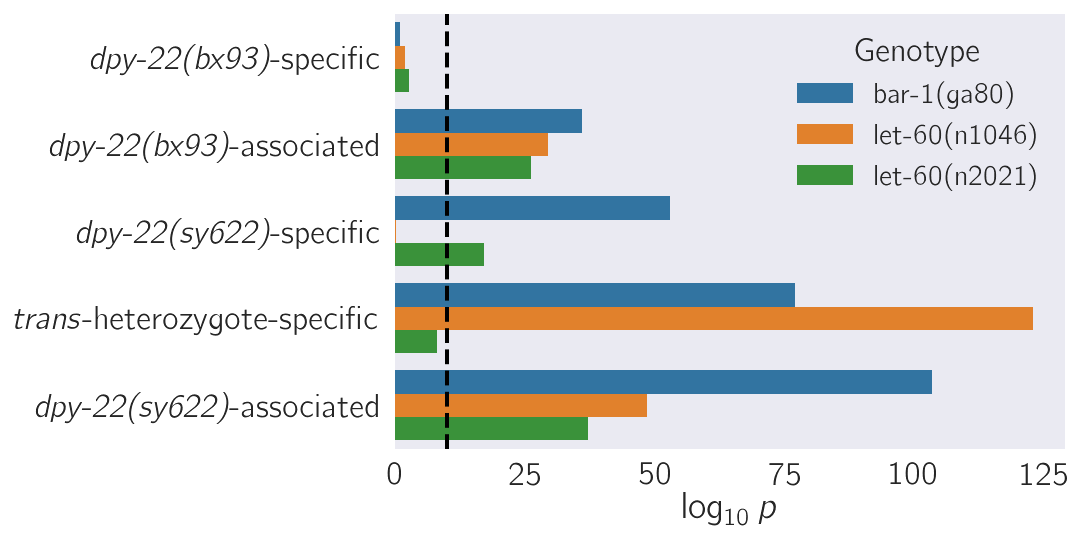

In [4]:
# call hypergeometric_phenotype_test using list comprehension (pythonic)
# then concatenate the resulting list of dataframes into a single df
pvals = pd.concat([hypergeometric_phenotype_test(genotype)
                   for genotype in
                   ['bar-1(ga80)', 'let-60(n2021)', 'let-60(n1046)']])

# sort the dataframe:
pvals.sort_values(['genotype','logpval'], inplace=True)

# barplot
sns.barplot(y='Phenotypic Class', x='logpval', hue='genotype',
            data=pvals)

# significance line:
plt.axvline(10, ls='--', lw=2, color='k')

# fancify the labels
plt.gca().set_yticklabels(['\emph{dpy-22(bx93)}-specific',
                           '\emph{dpy-22(bx93)}-associated',
                           '\emph{dpy-22(sy622)}-specific',
                           '\emph{trans}-heterozygote-specific',
                           '\emph{dpy-22(sy622)}-associated'])

# set xlabel and suppress ylabel:
plt.xlabel(r'$\log_{10}{p}$')
plt.ylabel('')

# fix legend title size:
leg = plt.legend()
leg.set_title(title='Genotype', prop={"size": 16})

# save:
plt.savefig('../output/stp_pvals.svg', bbox_inches='tight')

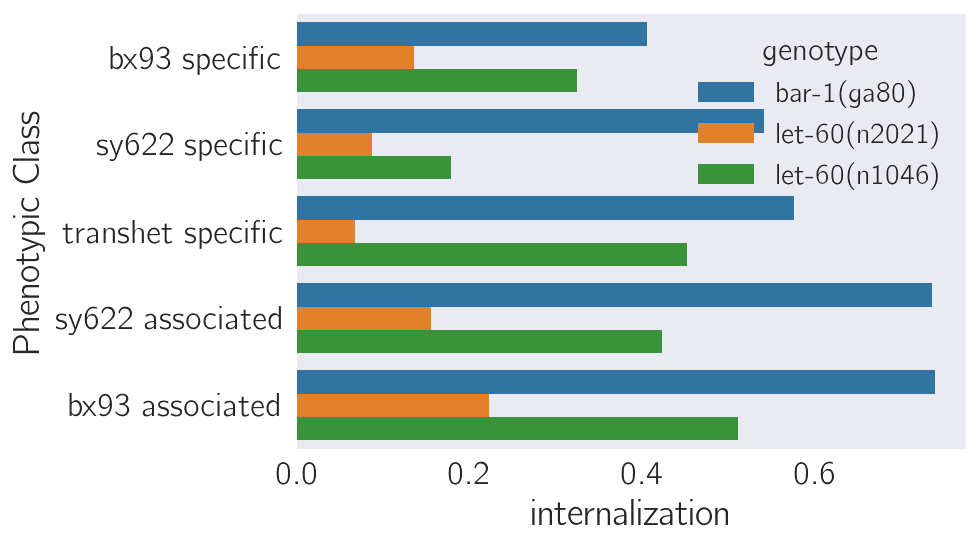

In [5]:
# do the same for the internalization:
intern = pd.concat([internalization(genotype) for genotype in
                   ['bar-1(ga80)', 'let-60(n2021)', 'let-60(n1046)']])

# plot:
sns.barplot(y='Phenotypic Class', x='internalization', hue='genotype',
            data=intern)

In [6]:
tissue = tea.fetch_dictionary('tissue')
phenotype = tea.fetch_dictionary('phenotype')
go = tea.fetch_dictionary('go')

dicts = {'tissue': tissue, 'phenotype': phenotype, 'go': go}

In [7]:
# filter dictionaries and keep only transcripts that were detected
#at any level
def filter(dicts, phenoclass):
    mod_d = {}
    cond = (quant.df['phenotypic class'] == phenoclass) & (quant.df.qval < q)
    for key, d in dicts.items():
        mod_d[key] = d[d.wbid.isin(quant.df[cond].ens_gene.unique())]
    return mod_d

In [8]:
def perform_ea(strain, dicts=dicts, exclude=None):
    cond = (quant.df.strain == strain) & (quant.df.qval < q)
    cond = (quant.df.qval < q)
    
    if exclude is not None:
        cond = cond & (exclude)
    
    analysis = {}
    
    for phenoclass, group in quant.df[cond].groupby('phenotypic class'):
        frames = {}
        mod_d = filter(dicts, phenoclass)
        tmp = group[group.strain == strain]
        for k, d in mod_d.items():
            df = tea.enrichment_analysis(tmp.ens_gene.unique(), d)
            df = df[df.Observed >= 3]
            frames[k] = df
        analysis[phenoclass] = frames
    
    # go through each analysis for each phenotypic class:
    print(quant.df[quant.df.strain == strain].fancy.values[0])
    for phenoclass, f in analysis.items():
        for k, d in f.items():
            d['logQ'] = -d['Q value'].apply(np.log10)
            # print significant terms
            sig = (d['Q value'] < 10**-3)
            
            # make sure the dataframe is not empty
            if d[sig].shape[0] == 0:
                continue

            if k.lower() == 'tissue':
                d['minTerm'] = d.Term.str[:-13]
            if k.lower() == 'phenotype':
                d['minTerm'] = d.Term.str[:-20]
            if k.lower() == 'go':
                d['minTerm'] = d.Term.str[:-10]
 

            # subset the dataframe to include only terms where at least
            # 4 genes were observed
            d['delta'] = np.abs(d.Observed - d.Expected)
            tmp = d[sig & (d.Observed > 3) & (d.delta > 1)]
            if len(tmp) == 0:
                continue
            
            # print the message:
            print(phenoclass, k)
            print(tmp[['minTerm', 'logQ', 'Observed']].round(0))

            # skip a couple of lines:
            print('\n\n')

In [9]:
common = quant.overlap(['EW15', 'MT4866', 'MT2124'])
exclude = (~quant.df.target_id.isin(common))

perform_ea('EW15', exclude=exclude)

bar-1(ga80)
bx93 associated phenotype
   minTerm  logQ  Observed
39    sick   inf         7
49   small   inf         4



bx93 associated go
                           minTerm  logQ  Observed
76  molecular transducer activity    inf         5
11        membrane-enclosed lumen    inf         5



sy622 associated tissue
    minTerm      logQ  Observed
219   Psub2       inf         5
22     male  3.000000        96



sy622 associated phenotype
                                         minTerm  logQ  Observed
56             pore forming toxin hypersensitive   inf         6
88                     embryonic lethal late emb   inf         5
80                         mRNA levels increased   inf         7
179                                   sterile F1   inf         4
115  Bacillus thuringiensis toxin hypersensitive   inf         6



sy622 associated go
                                               minTerm  logQ  Observed
91                purine nucleotide metabolic process    inf         

In [10]:
perform_ea('MT2124', exclude=exclude)

let-60(n1046)
bx93 associated phenotype
   minTerm  logQ  Observed
36   small   inf         4



sy622 associated tissue
    minTerm       logQ  Observed
211   Psub2        inf         5
20     male  18.000000        90
94   oocyte   4.000000        11



sy622 associated go
                           minTerm      logQ  Observed
34                    cell cortex        inf         4
102  phosphorus metabolic process   3.000000        29
36              dephosphorylation   3.000000        10



sy622 specific tissue
   minTerm  logQ  Observed
73  oocyte   4.0         6



transhet specific tissue
                  minTerm   logQ  Observed
16                   male  154.0       402
8      amphid sheath cell   17.0        60
136   reproductive system    4.0       381
47                   Z4.a    3.0        22
189                  Z1.p    3.0        22
187  male distal tip cell    3.0        22



transhet specific phenotype
                           minTerm  logQ  Observed
126  linker ce

In [11]:
perform_ea('MT4866', exclude=exclude)

let-60(n2021)
sy622 specific go
                               minTerm  logQ  Observed
36  structural constituent of cuticle   12.0        18
49                    collagen trimer   10.0        16



